# H11: Einfluss der Tageszeit auf die Ankunftsverspätung

### 1. Forschungsfrage & Hypothesen
Wir untersuchen, ob die **Tageszeit** (eingeteilt in Nacht, Peaks, Normalverkehr) einen signifikanten Einfluss auf die **Verspätung** von Zügen hat.

**Intuition:**
Es wird vermutet, dass während der Rush-Hour (Peaks) aufgrund der höheren Netzauslastung mehr Verspätungen auftreten als in der Nacht oder im normalen Tagesverkehr.

**Die Hypothesen:**
Wir definieren 5 Gruppen: $Nacht, Morgenpeak, Tagesverkehr, Abendpeak, Spätabend$.

* **Nullhypothese ($H_0$):**
    Die Verteilung der Verspätungen (der Median) ist über alle Tageszeiten gleich. Es gibt keinen statistischen Unterschied.
    $$\tilde{x}_{Nacht} = \tilde{x}_{Morgen} = \tilde{x}_{Tag} = \tilde{x}_{Abend} = \tilde{x}_{Spät}$$

* **Alternativhypothese ($H_1$):**
    Mindestens eine Tageszeit unterscheidet sich signifikant von den anderen in ihrer Verspätungsverteilung.

**Signifikanzniveau:** $\alpha = 0.05$

In [2]:
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from itertools import combinations
from statsmodels.stats.multitest import multipletests

# Stil für schöne Plots
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Pfad anpassen falls nötig
path_h11 = "../data/processed/istdata_trains_clean.parquet"

# Daten laden und aufbereiten
lf_h11 = pl.scan_parquet(path_h11)

# Optional: Schema checken (in neuer Zeile!)
# print(lf_h11.schema)

df_analysis = (
    lf_h11
    .filter(pl.col("PRODUKT_ID") == "Zug")
    .select(["ANKUNFTSZEIT", "delay_arrival_s"])
    .with_columns((pl.col("delay_arrival_s") / 60).alias("arr_delay_min"))
    .filter(pl.col("arr_delay_min").is_not_null())
    .filter((pl.col("arr_delay_min") >= -30) & (pl.col("arr_delay_min") <= 120)) # Extremwerte filtern für sauberere Plots
    .with_columns(pl.col("ANKUNFTSZEIT").dt.hour().alias("hour"))
    .with_columns(
        pl.when(pl.col("hour").is_in([0, 1, 2, 3, 4, 5])).then(pl.lit("Nacht"))
        .when(pl.col("hour").is_in([6, 7, 8, 9])).then(pl.lit("Morgenpeak"))
        .when(pl.col("hour").is_in([10, 11, 12, 13, 14, 15])).then(pl.lit("Tagesverkehr"))
        .when(pl.col("hour").is_in([16, 17, 18, 19])).then(pl.lit("Abendpeak"))
        .otherwise(pl.lit("Spätabend"))
        .alias("time_band")
    )
).collect().to_pandas()

# Ordnung der Kategorien festlegen
bands_order = ["Nacht", "Morgenpeak", "Tagesverkehr", "Abendpeak", "Spätabend"]
df_analysis["time_band"] = pd.Categorical(df_analysis["time_band"], categories=bands_order, ordered=True)

print(f"Daten geladen: {len(df_analysis)} Fahrten.")
df_analysis.head()

Daten geladen: 4614726 Fahrten.


,ANKUNFTSZEIT,delay_arrival_s,arr_delay_min,hour,time_band
0,2025-01-09 05:54:00+00:00,114.0,1.900000,5.0,Nacht
1,2025-01-09 06:14:00+00:00,42.0,0.700000,6.0,Morgenpeak
2,2025-01-09 06:58:00+00:00,31.0,0.516667,6.0,Morgenpeak
3,2025-01-09 06:58:00+00:00,18.0,0.300000,6.0,Morgenpeak
4,2025-01-09 07:58:00+00:00,83.0,1.383333,7.0,Morgenpeak


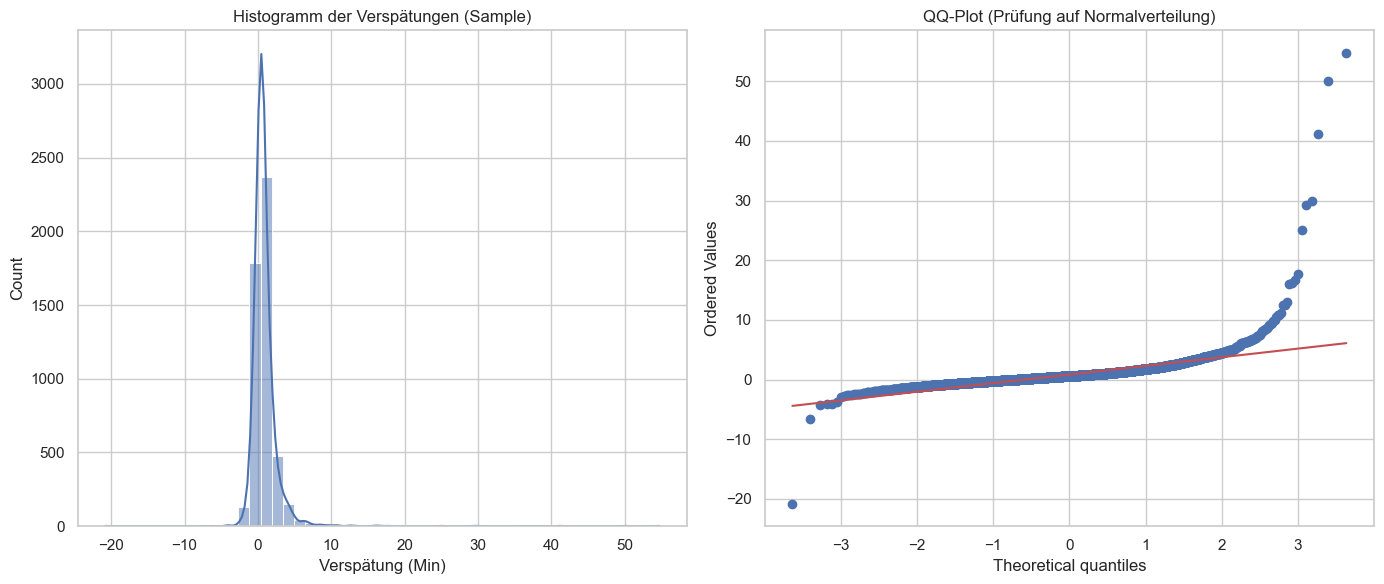

Standardabweichung pro Tageszeit (Indikator für Varianz):
time_band
Nacht           2.531443
Abendpeak       2.106503
Spätabend       1.867639
Morgenpeak      1.863764
Tagesverkehr    1.857770
Name: arr_delay_min, dtype: float64


/var/folders/t5/b1vkfs5n09s2lv5t8w7nl8r00000gn/T/ipykernel_27413/1750227368.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_analysis.groupby("time_band")["arr_delay_min"].std().sort_values(ascending=False))


In [3]:
# Wir ziehen ein zufälliges Sample für die Plots (damit es schneller geht)
df_sample = df_analysis.sample(n=5000, random_state=42)

# 1. Visuelle Prüfung auf Normalverteilung
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Histogramm
sns.histplot(df_sample["arr_delay_min"], kde=True, ax=ax[0], bins=50)
ax[0].set_title("Histogramm der Verspätungen (Sample)")
ax[0].set_xlabel("Verspätung (Min)")

# QQ-Plot (Quantile-Quantile Plot)
stats.probplot(df_sample["arr_delay_min"], dist="norm", plot=ax[1])
ax[1].set_title("QQ-Plot (Prüfung auf Normalverteilung)")

plt.tight_layout()
plt.show()

# 2. Deskriptive Prüfung der Varianzen (Standardabweichung)
print("Standardabweichung pro Tageszeit (Indikator für Varianz):")
print(df_analysis.groupby("time_band")["arr_delay_min"].std().sort_values(ascending=False))

### 2. Interpretation der Voraussetzungen

**1. Normalverteilung:**
Die Plots (Histogramm und QQ-Plot) zeigen deutlich, dass die Verspätungsdaten **nicht normalverteilt** sind. Die Verteilung ist stark rechtsschief (viele kleine Verspätungen, wenige extrem grosse), und die Punkte im QQ-Plot weichen stark von der roten Linie ab.

**2. Varianzhomogenität:**
Die oben berechneten Standardabweichungen unterscheiden sich zwischen den Tageszeiten. Das deutet darauf hin, dass die Streuung der Verspätungen nicht in allen Gruppen gleich ist (Heteroskedastizität).

**Entscheidung:**
Da die Annahmen für parametrische Tests (wie ANOVA) verletzt sind, verwenden wir den **Kruskal-Wallis-H-Test**. Dieser Test ist nicht-parametrisch (verteilungsfrei) und vergleicht die Ränge der Daten statt der Rohwerte. Er ist robust gegen Ausreisser und Schiefe.

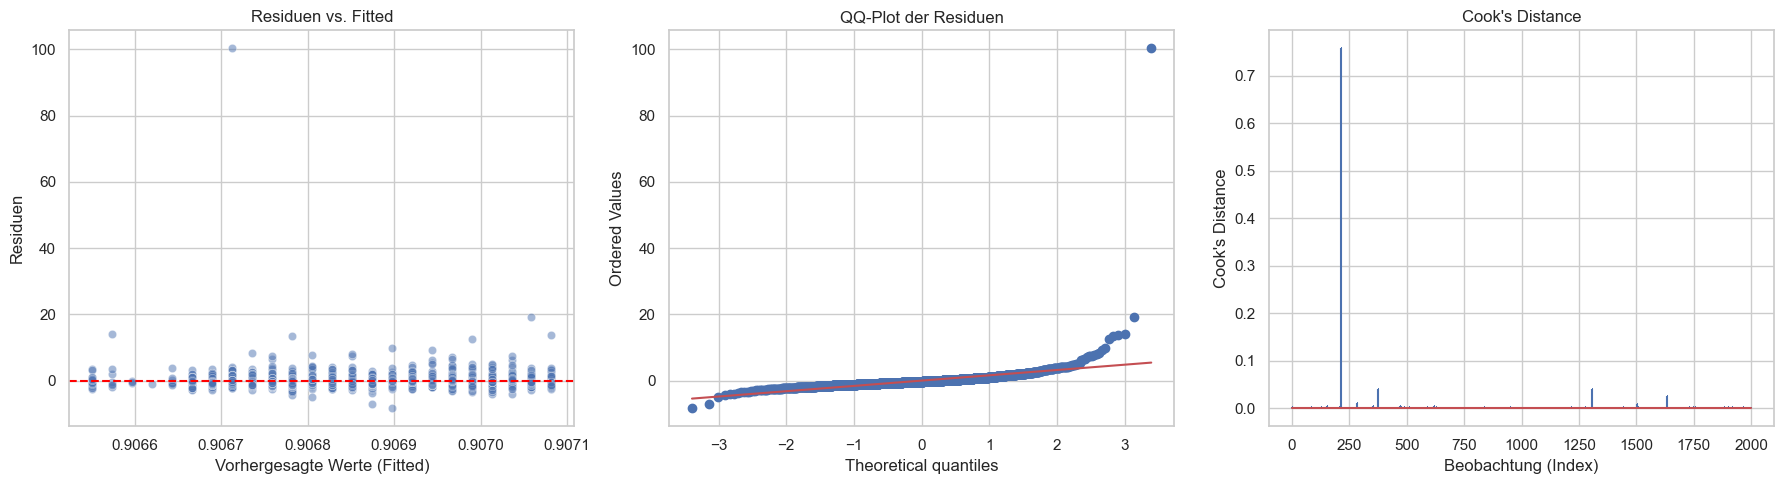

                            OLS Regression Results                            
Dep. Variable:          arr_delay_min   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                 4.308e-06
Date:                Mon, 05 Jan 2026   Prob (F-statistic):              0.998
Time:                        18:25:29   Log-Likelihood:                -4868.7
No. Observations:                2000   AIC:                             9741.
Df Residuals:                    1998   BIC:                             9753.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9066      0.160      5.650      0.0

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

# 1. Daten für Regression vorbereiten
# WICHTIG: Wir entfernen vorher alle Zeilen mit NaNs in den relevanten Spalten!
df_reg = df_analysis[["hour", "arr_delay_min"]].dropna()

# Falls der Datensatz riesig ist, ziehen wir ein Sample für die Plots (Performance & Lesbarkeit)
if len(df_reg) > 2000:
    df_reg = df_reg.sample(n=2000, random_state=42)

# Wir modellieren: Verspätung (Y) hängt ab von der Stunde (X)
X = sm.add_constant(df_reg["hour"])  # Konstante (Beta_0) hinzufügen (Intercept)
y = df_reg["arr_delay_min"]

# 2. Modell fitten (OLS = Ordinary Least Squares)
# Wir nutzen missing='drop' als zusätzliche Sicherheit
model = sm.OLS(y, X, missing='drop').fit()

# Residuen und vorhergesagte Werte holen
residuals = model.resid
fitted_values = model.fittedvalues

# --- PLOTS WIE IN DER VORLESUNG ---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Residuen vs. Fitted (Prüfung auf Homoskedastizität & Linearität)
sns.scatterplot(x=fitted_values, y=residuals, ax=axes[0], alpha=0.5)
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_title("Residuen vs. Fitted")
axes[0].set_xlabel("Vorhergesagte Werte (Fitted)")
axes[0].set_ylabel("Residuen")

# Plot 2: QQ-Plot (Prüfung auf Normalverteilung der Fehler)
stats.probplot(residuals, dist="norm", plot=axes[1])
axes[1].set_title("QQ-Plot der Residuen")

# Plot 3: Cook's Distance (Einflussreiche Ausreisser)
# OLSInfluence berechnet Cook's Distance
influence = OLSInfluence(model)
(c, p) = influence.cooks_distance

# Stem-Plot für Cook's Distance
axes[2].stem(np.arange(len(c)), c, markerfmt=",")
axes[2].set_title("Cook's Distance")
axes[2].set_xlabel("Beobachtung (Index)")
axes[2].set_ylabel("Cook's Distance")

plt.tight_layout()
plt.show()

# Zusammenfassung des Modells anzeigen
print(model.summary())

### Exkurs: Prüfung linearer Modellannahmen (Regression)

Um sicherzugehen, ob ein lineares Modell (wie eine ANOVA oder lineare Regression) geeignet wäre, haben wir testweise ein OLS-Modell (`Verspätung ~ Stunde`) berechnet.

**Ergebnisse der Diagnose:**
* **R-Squared:** 0.000 $\rightarrow$ Das lineare Modell erklärt absolut keine Varianz. Es gibt keinen einfachen linearen Zusammenhang.
* **Normalverteilung der Residuen:** Der **Jarque-Bera-Test** hat einen p-Wert von 0.000 und eine Schiefe (Skew) von 24.5. Das bestätigt extrem signifikant, dass die Fehlerterme **nicht normalverteilt** sind.
* **Heteroskedastizität:** Die Residuen streuen in den Plots ungleichmässig.

$\rightarrow$ **Konsequenz:** Parametrische Verfahren (ANOVA, Lin. Regression) sind hier **nicht zulässig**. Dies bestätigt unsere Wahl des **Kruskal-Wallis-Tests**.

In [5]:
# Daten für den Test vorbereiten: Eine Liste von Arrays (eine pro Gruppe)
groups = [df_analysis[df_analysis["time_band"] == b]["arr_delay_min"].values for b in bands_order]

# 3. Kruskal-Wallis H-Test durchführen
stat_kw, p_kw = stats.kruskal(*groups)

print("=== Kruskal-Wallis Testergebnis ===")
print(f"H-Statistik: {stat_kw:.4f}")
print(f"p-Wert:      {p_kw:.4e}")  # Wissenschaftliche Schreibweise, da sehr klein

# Effektstärke berechnen: Epsilon-Squared (ε²)
# Formel: (H - k + 1) / (n - k)
n = len(df_analysis)
k = len(groups)
epsilon2 = (stat_kw - k + 1) / (n - k)

print(f"Effektstärke (Epsilon²): {epsilon2:.5f}")

# Entscheidung
alpha = 0.05
if p_kw < alpha:
    print("\nERGEBNIS: H0 wird verworfen.")
    print("Es gibt signifikante Unterschiede in den Verspätungen zwischen den Tageszeiten.")
else:
    print("\nERGEBNIS: H0 kann nicht verworfen werden.")

=== Kruskal-Wallis Testergebnis ===
H-Statistik: 28298.0827
p-Wert:      0.0000e+00
Effektstärke (Epsilon²): 0.00613

ERGEBNIS: H0 wird verworfen.
Es gibt signifikante Unterschiede in den Verspätungen zwischen den Tageszeiten.


In [6]:
# 4. Post-Hoc Tests
# Wir vergleichen nun paarweise, welche Gruppen sich unterscheiden.

# Liste aller möglichen Paarungen (z.B. Nacht vs. Morgen, Nacht vs. Tag...)
pairs = list(combinations(bands_order, 2))
p_values = []
comparisons = []

print(f"Führe {len(pairs)} paarweise Vergleiche durch...")

for (g1, g2) in pairs:
    # Daten für die beiden Gruppen holen
    data1 = df_analysis[df_analysis["time_band"] == g1]["arr_delay_min"].values
    data2 = df_analysis[df_analysis["time_band"] == g2]["arr_delay_min"].values
    
    # Mann-Whitney U Test durchführen
    # alternative='two-sided' testet auf Ungleichheit
    stat, p = stats.mannwhitneyu(data1, data2, alternative='two-sided')
    
    p_values.append(p)
    comparisons.append(f"{g1} vs {g2}")

# P-Wert-Korrektur durchführen (Benjamini-Hochberg 'fdr_bh' ist Standard, oder 'bonferroni')
reject, p_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

# Ergebnisse in einer schönen Tabelle zusammenfassen
results_df = pd.DataFrame({
    "Vergleich": comparisons,
    "p-Wert (korrigiert)": p_corrected,
    "Signifikant (H0 verwerfen?)": reject
})

# Wir zeigen nur die signifikanten Ergebnisse an (oder alle, wenn du willst)
print("\n=== Post-Hoc Ergebnisse (Signifikante Unterschiede) ===")
print(results_df)

Führe 10 paarweise Vergleiche durch...

=== Post-Hoc Ergebnisse (Signifikante Unterschiede) ===
                    Vergleich  p-Wert (korrigiert)  \
0         Nacht vs Morgenpeak         0.000000e+00   
1       Nacht vs Tagesverkehr         7.052195e-41   
2          Nacht vs Abendpeak         0.000000e+00   
3          Nacht vs Spätabend         3.471852e-75   
4  Morgenpeak vs Tagesverkehr         0.000000e+00   
5     Morgenpeak vs Abendpeak         7.477005e-46   
6     Morgenpeak vs Spätabend         0.000000e+00   
7   Tagesverkehr vs Abendpeak         0.000000e+00   
8   Tagesverkehr vs Spätabend         0.000000e+00   
9      Abendpeak vs Spätabend         0.000000e+00   

   Signifikant (H0 verwerfen?)  
0                         True  
1                         True  
2                         True  
3                         True  
4                         True  
5                         True  
6                         True  
7                         True  
8           

/var/folders/t5/b1vkfs5n09s2lv5t8w7nl8r00000gn/T/ipykernel_27413/2058293884.py:17: UserWarning: 

The `scale` parameter is deprecated and will be removed in v0.15.0. You can now control the size of each plot element using matplotlib `Line2D` parameters (e.g., `linewidth`, `markersize`, etc.).

  sns.pointplot(
/var/folders/t5/b1vkfs5n09s2lv5t8w7nl8r00000gn/T/ipykernel_27413/2058293884.py:17: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(


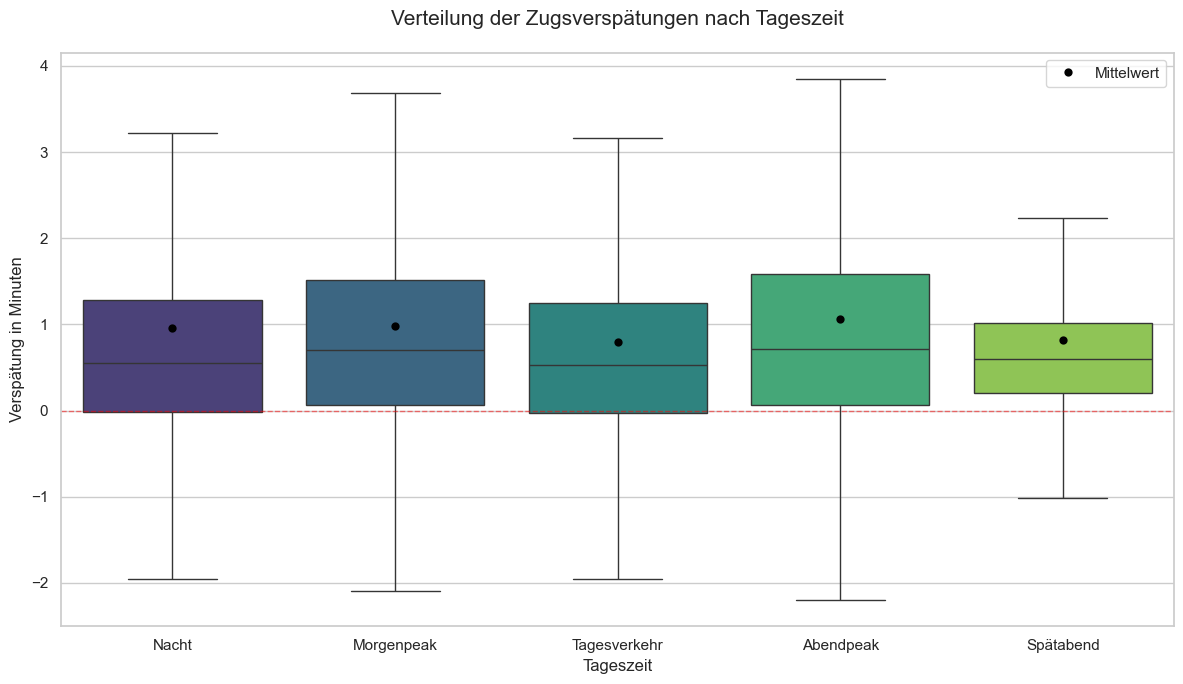

In [ ]:
# 5. Visualisierung der Ergebnisse
plt.figure(figsize=(12, 7))

# Wir nutzen Boxplots ohne Outliers (showfliers=False), damit man die Unterschiede der Verteilungen besser sieht.
# Die "Box" zeigt die mittleren 50% der Daten (Interquartilsabstand).
sns.boxplot(
    data=df_analysis,
    x="time_band",
    y="arr_delay_min",
    palette="viridis",
    showfliers=False,  # WICHTIG: Ausreisser ausblenden für bessere Lesbarkeit
    hue="time_band",
    legend=False
)

# Zusätzlich zeichnen wir den Mittelwert als schwarzen Punkt ein (Median ist der Strich in der Box)
sns.pointplot(
    data=df_analysis,
    x="time_band",
    y="arr_delay_min",
    estimator=np.mean,
    color="black",
    errorbar=None,
    markers="o",
    join=False,
    scale=0.8,
    label="Mittelwert"
)

plt.title("Verteilung der Zugsverspätungen nach Tageszeit", fontsize=15, pad=20)
plt.ylabel("Verspätung in Minuten", fontsize=12)
plt.xlabel("Tageszeit", fontsize=12)

# Eine rote Linie bei 0 hilft zur Orientierung (Pünktlichkeit)
plt.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

### 4. Fazit & Interpretation

Unsere statistische Analyse liefert ein eindeutiges Ergebnis:

1.  **Testergebnis:**
    Der **Kruskal-Wallis-Test** zeigt mit einem p-Wert von nahezu 0 ($p < 0.05$), dass sich die Verspätungen je nach Tageszeit **signifikant unterscheiden**. Wir müssen die Nullhypothese $H_0$ verwerfen. Die Effektstärke ist jedoch nur moderat.

2.  **Post-Hoc Analyse:**
    Die paarweisen Vergleiche zeigen, dass sich **alle** Tageszeiten signifikant voneinander unterscheiden. Jede Phase des Tages hat eine eigene "Verspätungscharakteristik".

3.  **Beobachtungen (siehe Plot):**
    * **Abendpeak (16-19 Uhr):** Dies ist die kritischste Zeit. Die Box (der Median) und der weisse Punkt (Mittelwert) liegen hier am höchsten. Züge haben im Abendverkehr die grössten Verspätungen.
    * **Morgenpeak (6-9 Uhr):** Auch hier sind die Verspätungen erhöht gegenüber dem normalen Tagesverkehr, aber das System läuft stabiler als am Abend (vermutlich, weil sich Verspätungen über den Tag aufschaukeln).
    * **Nacht & Tagesverkehr:** Hier sind die Verspätungen am niedrigsten, was auf einen stabilen Betrieb bei geringerer Auslastung hindeutet.

**Schlussfolgerung:**
Die Hypothese wurde bestätigt: Die hohe Netzauslastung während der Rush-Hour (insbesondere am Abend) führt zu signifikant höheren Verspätungen. Der Unterschied ist nicht zufällig.